# Feb ??th, 2022 (debug, misc)

**Motivation**: Figs for talk on 25th  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


from scipy.ndimage import gaussian_filter

def show_h(proj_h, proj_hr, idx: int = 0, cmap='icefire', interp='antialiased'):
    fig, axes = create_figure(
        1, 4, (10., 2), width_ratios=[1.7, 1, 1, 1.7])

    x2plt = proj_h['flat'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[0].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[0], shrink=0.4)

    x2plt = proj_h['top'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[1].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['top'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    axes[2].imshow(x2plt, cmap=cmap, interpolation=interp)

    x2plt = proj_hr['flat'][idx]
    x2plt = gaussian_filter(x2plt, sigma=1)
    x2plt = np.ma.masked_where(x2plt < 0.01, x2plt)
    im = axes[3].imshow(x2plt, cmap=cmap, interpolation=interp)
    plt.colorbar(im, ax=axes[3], shrink=0.4)

    remove_ticks(axes)
    plt.show()

## Prepare

In [3]:
mice = Mice((128, 0, 100))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bold = {'mode': 'bold-lite', **props_base}

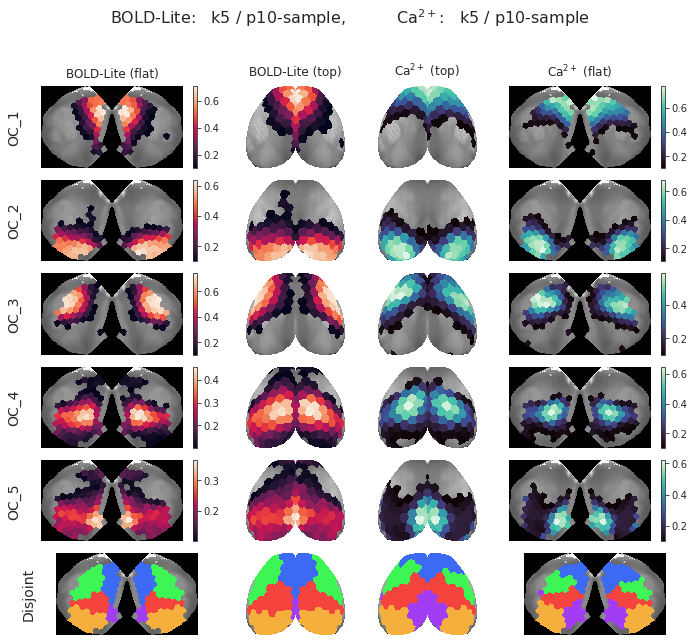

BOLD   : : :   ovp: 0.9943,  disj: 0.9816

Ca2    : : :   ovp: 0.9874,  disj: 0.9494

[0, 1, 2, 3, 4]

In [4]:
gr_ca = Group(**props_ca).fit_group()
gr_bold = Group(**props_bold).fit_group()

sim = dist2sim(sp_dist.cdist(
    XA=gr_bold.grp_pi,
    XB=gr_ca.grp_pi,
    metric='cosine',
))
mapping = find_best_match(sim)
ids = list(mapping.values())

gr_bold.pi = gr_bold.grp_pi
gr_ca.pi = gr_ca.grp_pi[ids]

proj_bold = gr_bold.project_vec()
proj_ca = gr_ca.project_vec()

fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    min_thres=0.1,
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

display(fig)

ovp, disj = gr_bold.pi_symmetry_score(decimals=5)
print(f"BOLD   : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")
ovp, disj = gr_ca.pi_symmetry_score(decimals=5)
print(f"Ca2    : : :   ovp: {ovp[-1]:0.4f},  disj: {disj[-1]:0.4f}")

ids

## Entropy

In [56]:
gr_ca_pruned_h = Group(**props_ca).load_group(use_pruned_for_h=True)
gr_bold_pruned_h = Group(**props_bold).load_group(use_pruned_for_h=True)

gr_ca_full_h = Group(**props_ca).load_group(use_pruned_for_h=False)
gr_bold_full_h = Group(**props_bold).load_group(use_pruned_for_h=False)

grp_h_new_ca = sp_stats.entropy(gr_ca.grp_pi_prune, axis=-2) / np.log(gr_ca.num_k)
grp_h_new_bold = sp_stats.entropy(gr_bold.grp_pi_prune, axis=-2) / np.log(gr_bold.num_k)

run_h_avg_ca = bn.nanmean(bn.nanmean(bn.nanmean(gr_ca_pruned_h.run_h, 2), 1), 0)
run_h_avg_bold = bn.nanmean(bn.nanmean(bn.nanmean(gr_bold_pruned_h.run_h, 2), 1), 0)

pruned:

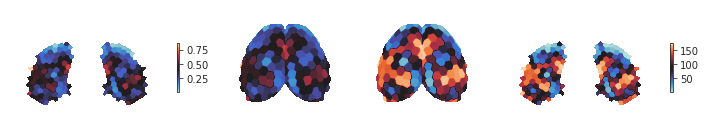

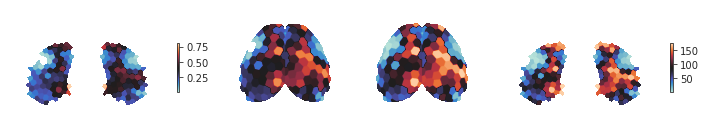

pruned, but new:

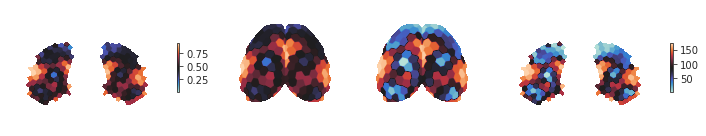

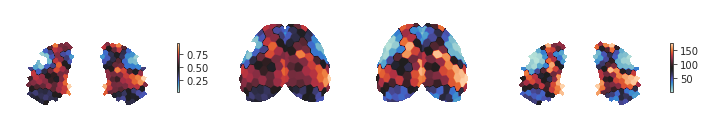

pruned, but run avg:

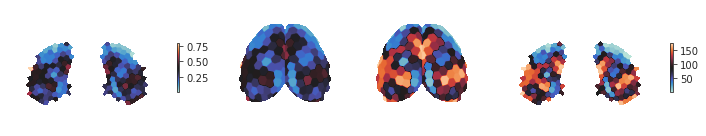

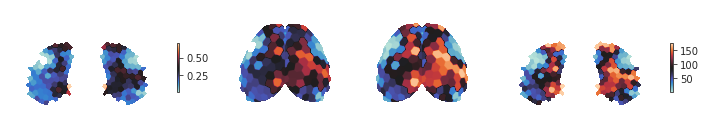

full:

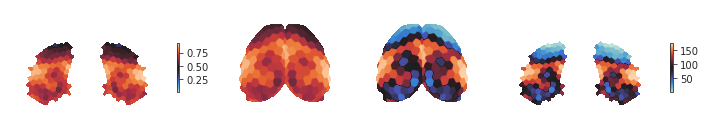

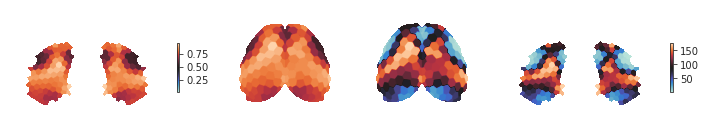

In [59]:
print('pruned:')
show_h(
    gr_ca_pruned_h.project_vec(gr_ca_pruned_h.grp_h, add_disjoint=False),
    gr_ca_pruned_h.project_vec(gr_ca_pruned_h.grp_hr, add_disjoint=False),
)
show_h(
    gr_bold_pruned_h.project_vec(gr_bold_pruned_h.grp_h, add_disjoint=False),
    gr_bold_pruned_h.project_vec(gr_bold_pruned_h.grp_hr, add_disjoint=False),
)

print('\npruned, but new:')
show_h(
    gr_ca.project_vec(grp_h_new_ca, add_disjoint=False),
    gr_ca.project_vec(sp_stats.rankdata(grp_h_new_ca), add_disjoint=False),
)
show_h(
    gr_bold.project_vec(grp_h_new_bold, add_disjoint=False),
    gr_bold.project_vec(sp_stats.rankdata(grp_h_new_bold), add_disjoint=False),
)

print('\npruned, but run avg:')
show_h(
    gr_ca.project_vec(run_h_avg_ca, add_disjoint=False),
    gr_ca.project_vec(sp_stats.rankdata(run_h_avg_ca), add_disjoint=False),
)
show_h(
    gr_bold.project_vec(run_h_avg_bold, add_disjoint=False),
    gr_bold.project_vec(sp_stats.rankdata(run_h_avg_bold), add_disjoint=False),
)

print('\n full:')
show_h(
    gr_ca_full_h.project_vec(gr_ca_full_h.grp_h, add_disjoint=False),
    gr_ca_full_h.project_vec(gr_ca_full_h.grp_hr, add_disjoint=False),
)
show_h(
    gr_bold_full_h.project_vec(gr_bold_full_h.grp_h, add_disjoint=False),
    gr_bold_full_h.project_vec(gr_bold_full_h.grp_hr, add_disjoint=False),
)

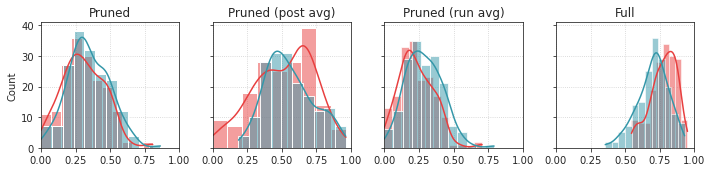

In [60]:
fig, axes = create_figure(1, 4, (10, 2.5), 'all', 'all')

sns.histplot(gr_bold_pruned_h.grp_h, kde=True, color=pal['bold-lite'], ax=axes[0])
sns.histplot(gr_ca_pruned_h.grp_h, kde=True, color=pal['ca2'], ax=axes[0])

sns.histplot(grp_h_new_bold, kde=True, color=pal['bold-lite'], ax=axes[1])
sns.histplot(grp_h_new_ca, kde=True, color=pal['ca2'], ax=axes[1])

sns.histplot(run_h_avg_bold, kde=True, color=pal['bold-lite'], ax=axes[2])
sns.histplot(run_h_avg_ca, kde=True, color=pal['ca2'], ax=axes[2])

sns.histplot(gr_bold_full_h.grp_h, kde=True, color=pal['bold-lite'], ax=axes[3])
sns.histplot(gr_ca_full_h.grp_h, kde=True, color=pal['ca2'], ax=axes[3])

axes[0].set_title('Pruned')
axes[1].set_title('Pruned (post avg)')
axes[2].set_title('Pruned (run avg)')
axes[3].set_title('Full')
axes[0].set_xlim(0, 1)
add_grid(axes)
plt.show()

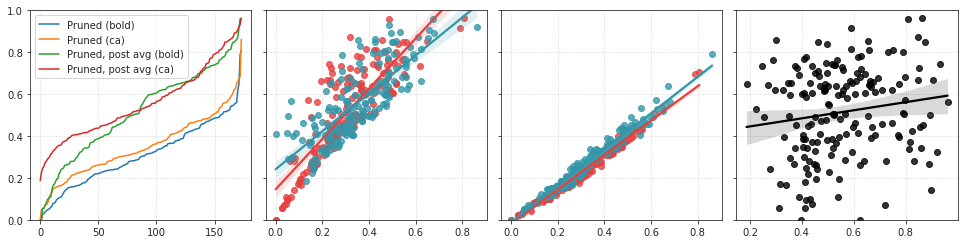

In [62]:
fig, axes = create_figure(1, 4, figsize=(13.5, 3.5), sharey='all')
axes[0].plot(sorted(gr_bold.grp_h), label='Pruned (bold)')
axes[0].plot(sorted(gr_ca.grp_h), label='Pruned (ca)')
axes[0].plot(sorted(grp_h_new_bold), label='Pruned, post avg (bold)')
axes[0].plot(sorted(grp_h_new_ca), label='Pruned, post avg (ca)')
axes[0].legend()
axes[0].set_ylim(0, 1)

sns.regplot(x=gr_bold.grp_h, y=grp_h_new_bold, color=pal['bold-lite'], ax=axes[1])
sns.regplot(x=gr_ca.grp_h, y=grp_h_new_ca, color=pal['ca2'], ax=axes[1])

sns.regplot(x=gr_bold.grp_h, y=run_h_avg_bold, color=pal['bold-lite'], ax=axes[2])
sns.regplot(x=gr_ca.grp_h, y=run_h_avg_ca, color=pal['ca2'], ax=axes[2])

sns.regplot(x=grp_h_new_ca, y=grp_h_new_bold, color='k', ax=axes[3])
# sns.regplot(x=grp_h_new_bold, y=grp_h_new_ca, color=pal['ca2'], ax=axes[3])
# sns.regplot(x=gr_ca.grp_h, y=gr_bold.grp_h, color='k', ax=axes[3])

add_grid(axes)

plt.show()

[<matplotlib.lines.Line2D object at 0x7f29caa58bb0>]

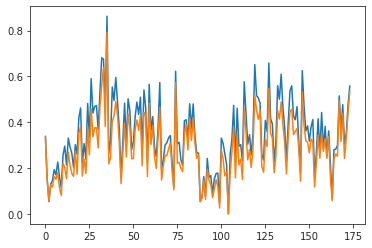

In [64]:
plt.plot(gr_ca.grp_h)
plt.plot(run_h_avg_ca)

## TODO: make a pairplot (add the bold, ca stuff there and tag pruned vs post avg vs full)

## Stacked bar plot

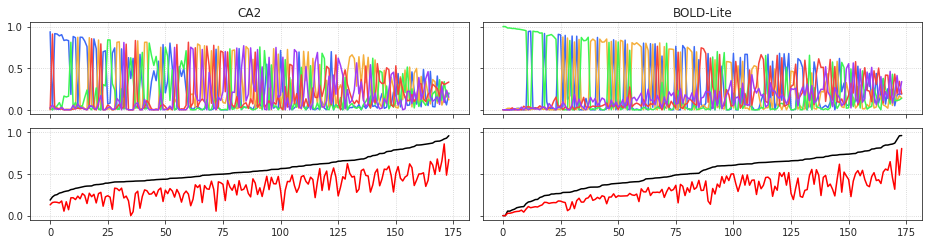

In [70]:


fig, axes = create_figure(2, 2, (13, 3.5), 'all', 'all')

sort = np.argsort(grp_h_new_ca)
for i in range(gr_ca.num_k):
    axes[0, 0].plot(gr_ca.grp_pi_prune[i][sort], color=gr_ca.colors[i + 1])
axes[1, 0].plot(grp_h_new_ca[sort], color='k')
axes[1, 0].plot(gr_ca.grp_h[sort], color='r')
axes[0, 0].set_title('CA2')

sort = np.argsort(grp_h_new_bold)
for i in range(gr_bold.num_k):
    axes[0, 1].plot(gr_bold.grp_pi_prune[i][sort], color=gr_bold.colors[i + 1])
axes[1, 1].plot(grp_h_new_bold[sort], color='k')
axes[1, 1].plot(gr_bold.grp_h[sort], color='r')
axes[0, 1].set_title('BOLD-Lite')

add_grid(axes)
plt.show()

## Top & Flat

In [4]:
mice = Mice((128, 0, 100))

In [ ]:
# HIDE CODE


from register.atlas import Allen

# cortical map parcel flatt & top
al10 = Allen(10, full_load=False)
template = al10.mcc.get_template_volume()[0]

top = al10.cortical_map(template, proj='top_view', agg_func=np.max)
flatmap = al10.cortical_map(template, proj='dorsal_flatmap', agg_func=np.max)

In [5]:
# load parcel flatt & top
parcel_flat = 'parcel2d-flat_10um.nii.gz'
parcel_flat = pjoin(mice.cfg.parcel_dir, parcel_flat)
parcel_flat = ants.image_read(parcel_flat).numpy()

parcel_top = 'parcel2d-top_10um.nii.gz'
parcel_top = pjoin(mice.cfg.parcel_dir, parcel_top)
parcel_top = ants.image_read(parcel_top).numpy()

In [7]:
figs_dir = pjoin(tmp_dir, 'fig_topflat')
os.makedirs(figs_dir, exist_ok=True)

### Top

In [53]:
fig, ax = create_figure(figsize=(13, 20))
ax.imshow(top, cmap='Greys_r')
fig.savefig(pjoin(figs_dir, 'top.pdf'), bbox_inches='tight')
plt.close()

fig, ax = create_figure(figsize=(13, 20))
ax.imshow(top, cmap='Greys_r')
remove_ticks(ax)
fig.savefig(pjoin(figs_dir, 'top_noticks.pdf'), bbox_inches='tight')
plt.close()

In [54]:
top_tr = filter_boundaries(top)

In [55]:
fig, ax = create_figure(figsize=(13, 20))
ax.imshow(top_tr, cmap='Greys_r')
fig.savefig(pjoin(figs_dir, 'top_tr.pdf'), bbox_inches='tight')
plt.close()

fig, ax = create_figure(figsize=(13, 20))
ax.imshow(top_tr, cmap='Greys_r')
remove_ticks(ax)
fig.savefig(pjoin(figs_dir, 'top_tr_noticks.pdf'), bbox_inches='tight')
plt.close()

fig, ax = create_figure(figsize=(13, 20))
x2plt = np.ma.masked_where(top_tr == 0, top_tr)
ax.imshow(x2plt, cmap='Greys_r')
remove_ticks(ax)
fig.savefig(pjoin(figs_dir, 'top_tr_masked.pdf'), bbox_inches='tight')
plt.close()

### Flat

In [56]:
fig, ax = create_figure(figsize=(23, 10))
ax.imshow(flatmap, cmap='Greys_r')
fig.savefig(pjoin(figs_dir, 'flat.pdf'), bbox_inches='tight')
plt.close()

fig, ax = create_figure(figsize=(23, 10))
ax.imshow(flatmap, cmap='Greys_r')
remove_ticks(ax)
fig.savefig(pjoin(figs_dir, 'flat_noticks.pdf'), bbox_inches='tight')
plt.close()

In [57]:
flat_tr = filter_boundaries(flatmap)

In [58]:
fig, ax = create_figure(figsize=(23, 10))
ax.imshow(flat_tr, cmap='Greys_r')
fig.savefig(pjoin(figs_dir, 'flat_tr.pdf'), bbox_inches='tight')
plt.close()

fig, ax = create_figure(figsize=(23, 10))
ax.imshow(flat_tr, cmap='Greys_r')
remove_ticks(ax)
fig.savefig(pjoin(figs_dir, 'flat_tr_noticks.pdf'), bbox_inches='tight')
plt.close()

fig, ax = create_figure(figsize=(23, 10))
x2plt = np.ma.masked_where(flat_tr == 0, flat_tr)
ax.imshow(x2plt, cmap='Greys_r')
remove_ticks(ax)
fig.savefig(pjoin(figs_dir, 'flat_tr_masked.pdf'), bbox_inches='tight')
plt.close()

## Joannes

In [4]:
_dir = '/home/hadi/Downloads'
file = 'DSURQE_100micron_DRICA.nii.gz'
file = pjoin(_dir, file)
img = ants.image_read(file)

In [6]:
x = img.numpy()

In [7]:
x.shape

(126, 191, 96, 18)

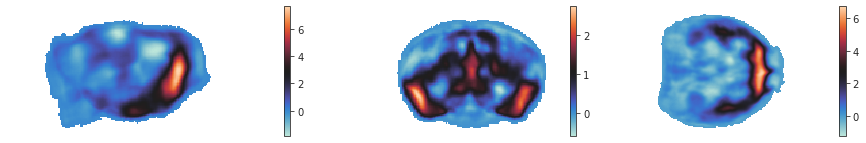

In [121]:
fig, axes = create_figure(1, 3, (13, 2.1), width_ratios=[1.4, 1., 1])
for i in range(3):
    x2plt = x[..., 0].mean(i)
    if i != 2:
        x2plt = x2plt[:, ::-1].T
    x2plt = np.ma.masked_where(x2plt == 0, x2plt)
    im = axes[i].imshow(x2plt, cmap='icefire')
    plt.colorbar(im, ax=axes[i])
remove_ticks(axes)
plt.show()

## Load stuff

In [45]:
_dir = '/mnt/storage/hadi/Ca-fMRI/gabe_data/LPS_orient/cleaned_timeseries'
file = 'sub-SLC08_ses-3_task-rest_run-7_bold_combined_cleaned_LPS.nii.gz'
file = pjoin(_dir, file)
img = ants.image_read(file)

In [46]:
img

ANTsImage
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 88, 55, 448)
         Spacing    : (0.2, 0.2, 0.2, 1.0)
         Origin     : (19.0, 7.15, -5.4, 0.0)
         Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

In [47]:
x = img.numpy()

<matplotlib.colorbar.Colorbar object at 0x7fcd5c8c7850>

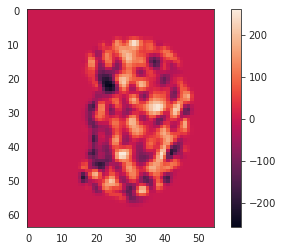

In [55]:
plt.imshow(x[:, 40, :, 93])
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7fd05abb56a0>

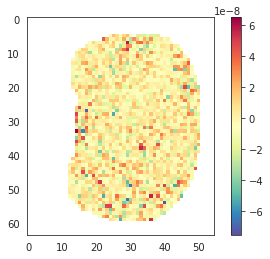

In [48]:
snr = x.mean(-1) / x.std(-1)
plt.imshow(snr[:, 40, :], cmap='Spectral_r')
plt.colorbar()

In [59]:
_dir = '/mnt/storage/hadi/Ca-fMRI/gabe_data/LPS_orient/brain_mask'
file = 'sub-SLC08_ses-3_task-rest_run-7_bold_EPI_brain_mask_LPS.nii.gz'
file = pjoin(_dir, file)
mask = ants.image_read(file)
mask

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 88, 55)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (19.0, 7.15, -5.4)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.image.AxesImage object at 0x7fd0397cf550>

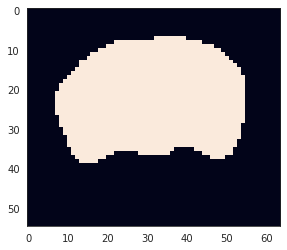

In [70]:
plt.imshow(mask.numpy()[:, 40, :].T[::-1][:, ::-1])

In [62]:
mice.setup_anat_data()

In [64]:
t1w = mice.T1w['sub-SLC08_ses-3'].load_ants()
t1w

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.image.AxesImage object at 0x7fcd4bdd6640>

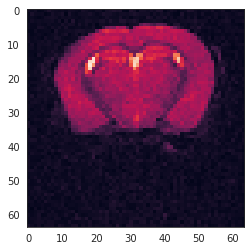

In [67]:
plt.imshow(t1w[:, :, 40].T)

<matplotlib.image.AxesImage object at 0x7fd039ab4940>

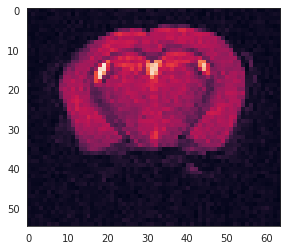

In [82]:
plt.imshow(t1w[:, :, 40].T[:55])

In [83]:
t1w.shape

(64, 64, 78)

In [84]:
x = mask.numpy()[::-1][..., ::-1]
x.shape

(64, 88, 55)

<matplotlib.image.AxesImage object at 0x7fd0395ccb80>

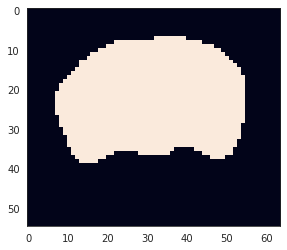

In [85]:
plt.imshow(x[:, 40, :].T)

In [81]:
test = pjoin(mice.cfg.raw_dir, 'sub-SLC08_ses-3_acq-isotropic_T1w.nii.gz')
test = ants.image_read(test)
test

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [80]:
mask

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 88, 55)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (19.0, 7.15, -5.4)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

<matplotlib.image.AxesImage object at 0x7fd038dc82e0>

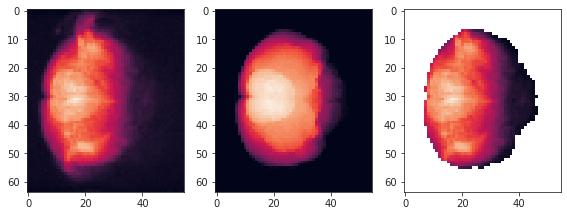

In [96]:
a = t1w.mean(-1)[:, :55]
b = mask.mean(1)[::-1][:, ::-1]

fig, axes = create_figure(1, 3, (8, 3))
axes[0].imshow(a)
axes[1].imshow(b)
axes[2].imshow(np.ma.masked_where(b == 0, a))

<matplotlib.image.AxesImage object at 0x7fd0393f9940>

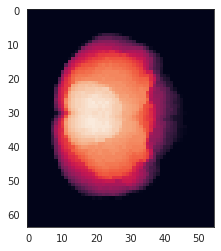

In [88]:
plt.imshow()

## Previous Debugs

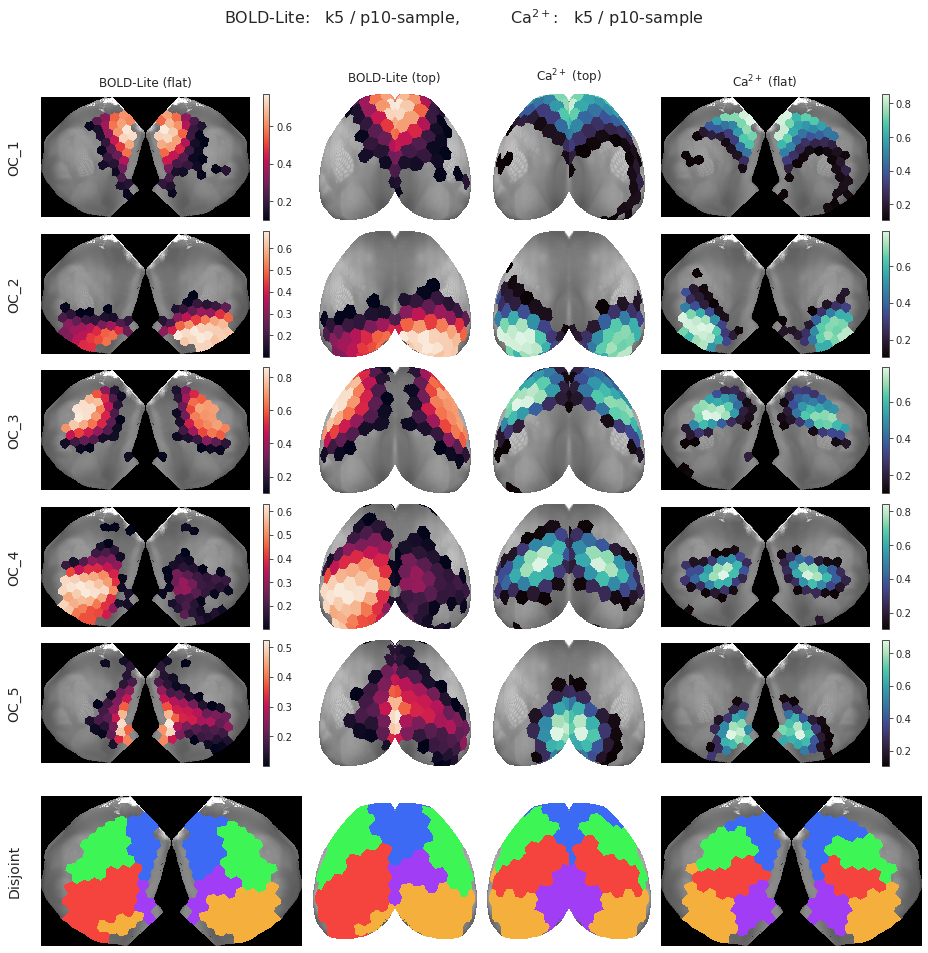

In [8]:
fig, _ = gr_ca.show(
    proj_bold, proj_ca,
    labels=('BOLD-Lite', r'Ca$^{2+}$'),
    cmaps=('rocket', 'mako'),
    display=False,
)
sup = f"BOLD-Lite:   k{props_bold.get('num_k')} / {props_bold.get('perc')},          "
sup += r"Ca$^{2+}$:   " + f"k{props_ca.get('num_k')} / {props_ca.get('perc')}"
sup = fig.suptitle(sup, fontsize=16, y=1.02)

fig

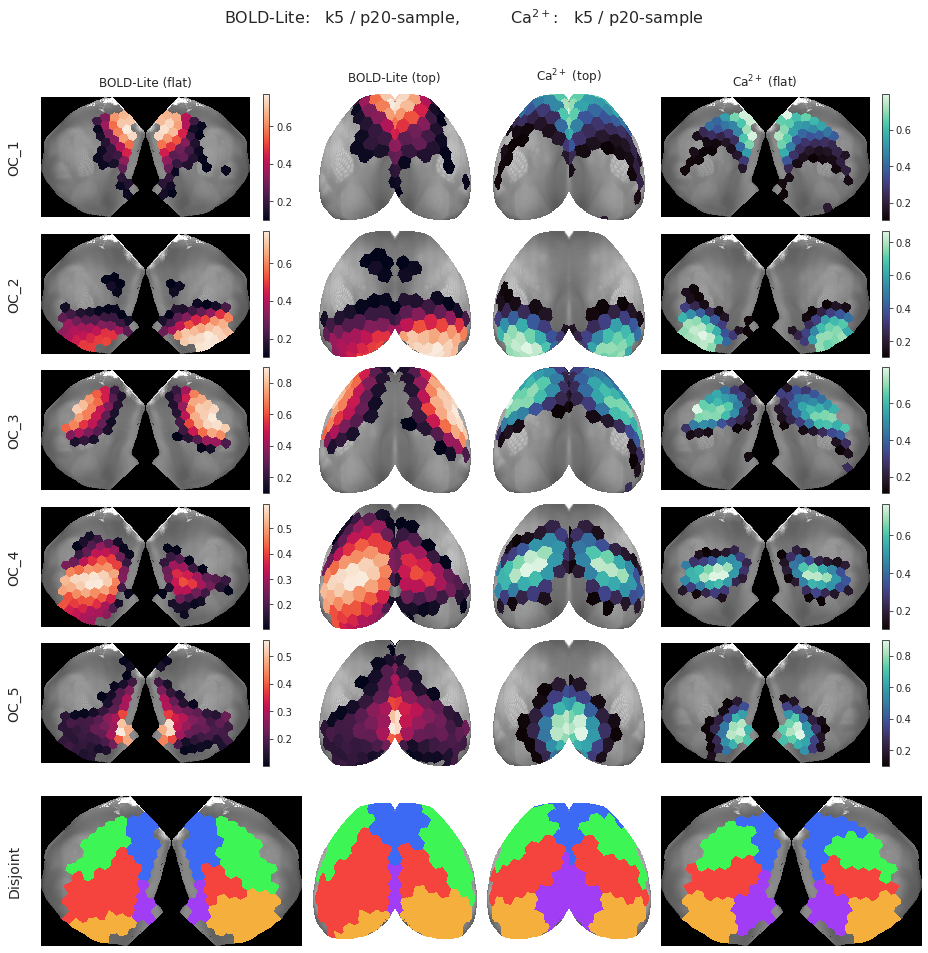

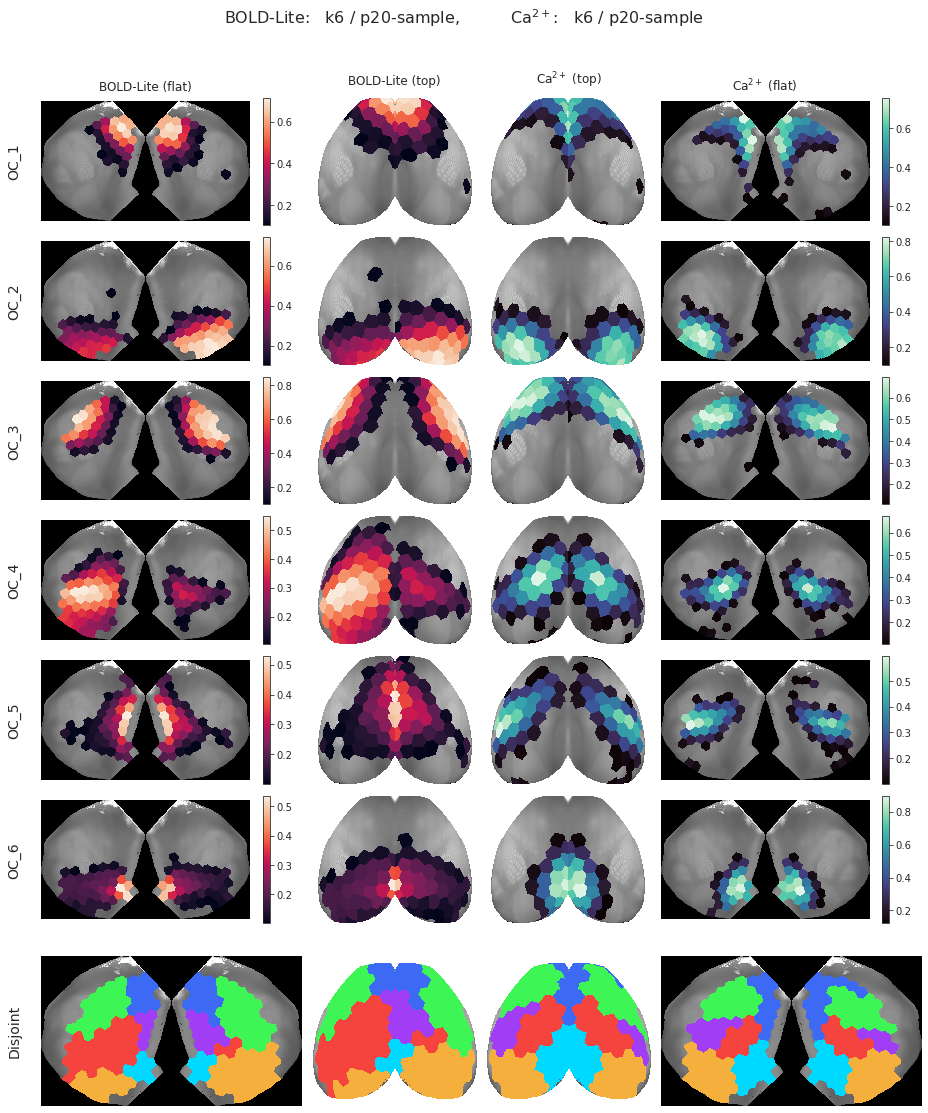

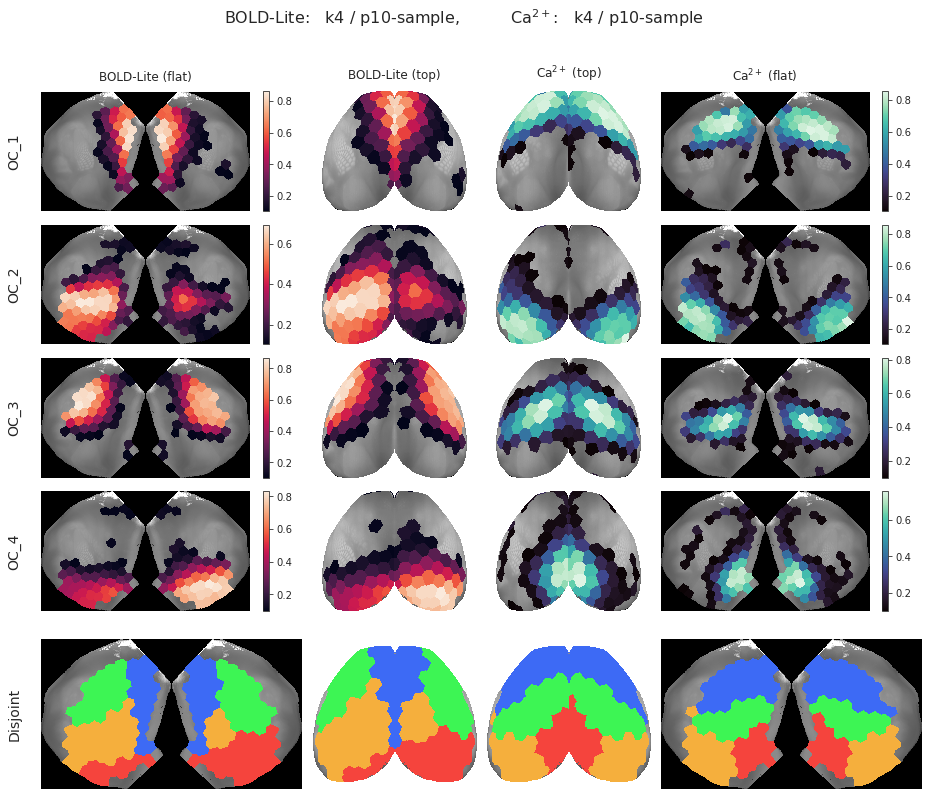

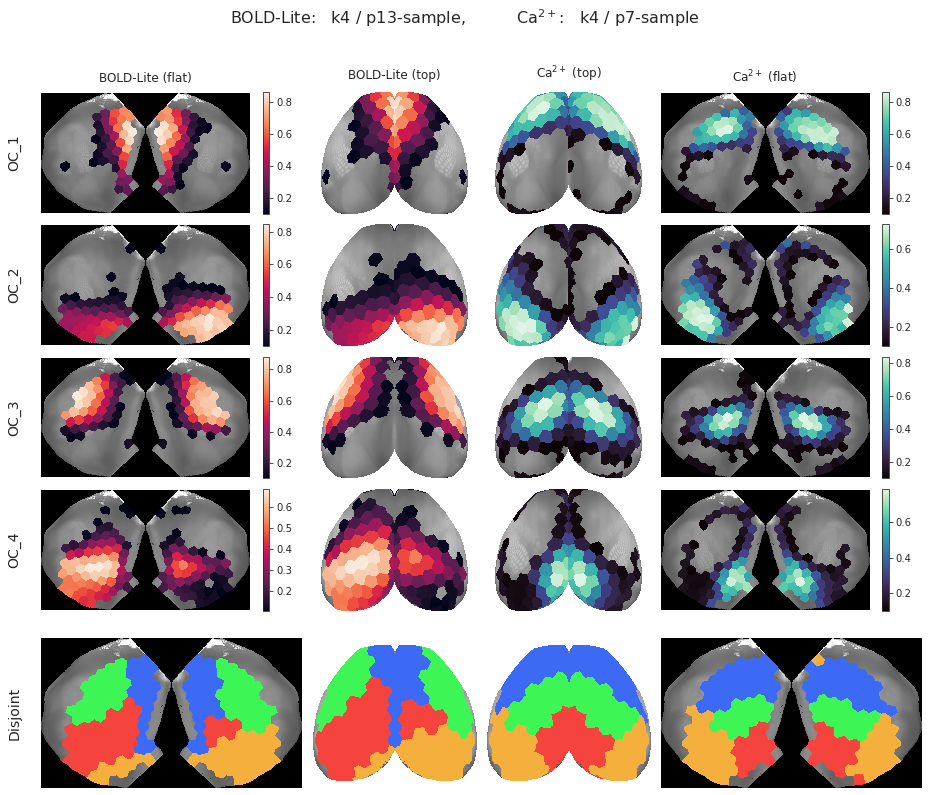

## Debug svinet

In [3]:
key = 'sub-SLC07_ses-2_run-5'
sv = SVINET(mice, num_k=4, key=key, perc='p13-sample', mode='bold-lite')

current expt: 'p13-sample'

In [4]:
sv.data

In [4]:
%%time

_ = sv.load_runs()
_ = sv.fit_svinet()

[PROGRESS] experiment loaded: 'k = 4, p13-sample',  total # runs:  500

[PROGRESS] fit: initiated

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

[PROGRESS] find best mappings: done

[PROGRESS] results aligned: done

[PROGRESS] align: done

[PROGRESS] 'gam.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*0/results/SVINET/n-1
28*0_bold-lite_rest_pearson_sub-SLC07_ses-2_run-5/real-k4-p13-sample-euclidean-linksampling-(
2022_01_14)

[PROGRESS] 'lam.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*0/results/SVINET/n-1
28*0_bold-lite_rest_pearson_sub-SLC07_ses-2_run-5/real-k4-p13-sample-euclidean-linksampling-(
2022_01_14)

[PROGRESS] 'pi.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*0/results/SVINET/n-1
28*0_bold-lite_rest_pearson_sub-SLC07_ses-2_run-5/real-k4-p13-sample-euclidean-linksampling-(
2022_01_14)

[PROGRESS] 'perms.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*0/results/SVINET/n-1
28*0_bold-lite_rest_pearson_sub-SLC07_ses-2_run-5/real-k4-p13-sample-euclidean-linksampling-(
2022_01_14)

[PROGRESS] 'gam_all.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*0/results/SVINET/n-1
28*0_bold-lite_rest_pearson_sub-SLC07_ses-2_run-5/real-k4-p13-sample-euclidean-linksampling-(
2022_01_14)

[PROGRESS] 'lam_all.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*0/results/SVINET/n-1
28*0_bold-lite_rest_pearson_sub-SLC07_ses-2_run-5/real-k4-p13-sample-euclidean-linksampling-(
2022_01_14)

[PROGRESS] 'pi_all.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*0/results/SVINET/n-1
28*0_bold-lite_rest_pearson_sub-SLC07_ses-2_run-5/real-k4-p13-sample-euclidean-linksampling-(
2022_01_14)

[PROGRESS] fit: done!

CPU times: user 9.08 s, sys: 546 ms, total: 9.62 s
Wall time: 3.65 s


In [5]:
sv.pi_symmetry_score()

{1: 0.91, 2: 0.59, 3: 0.9, 4: 0.6, -1: 0.75}

In [5]:
sv.pi_symmetry_score()

{1: 0.84, 2: 0.5, 3: 0.8, 4: 0.47, -1: 0.65}

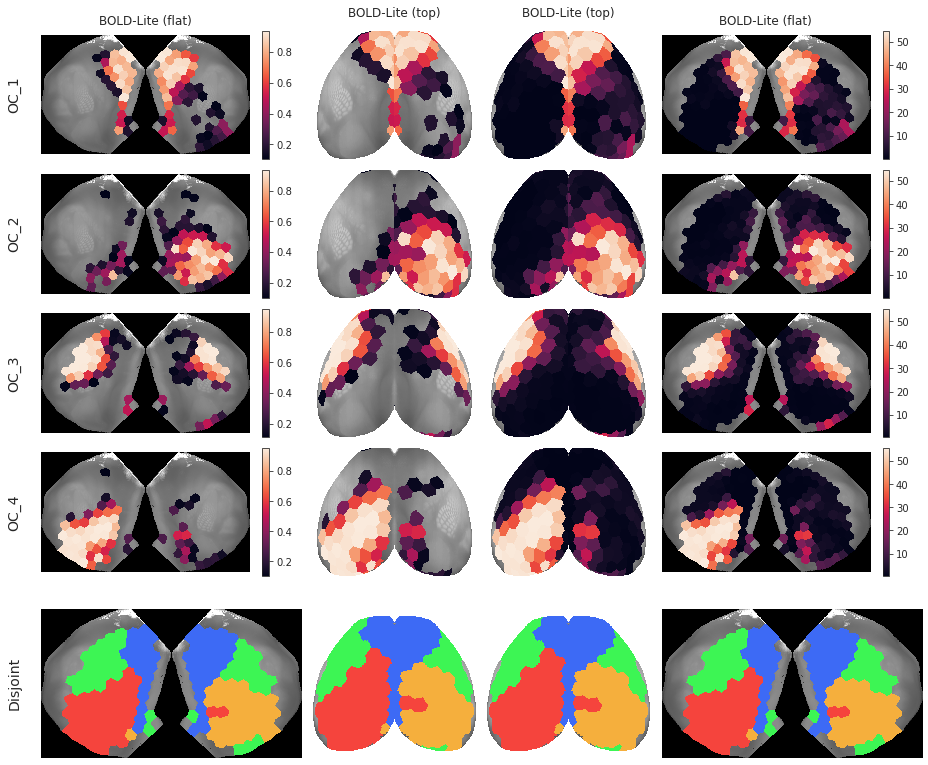

In [8]:
_ = sv.show(
    sv.project_vec(sv.pi),
    sv.project_vec(sv.gam),
    cmaps=('rocket', 'rocket'),
)

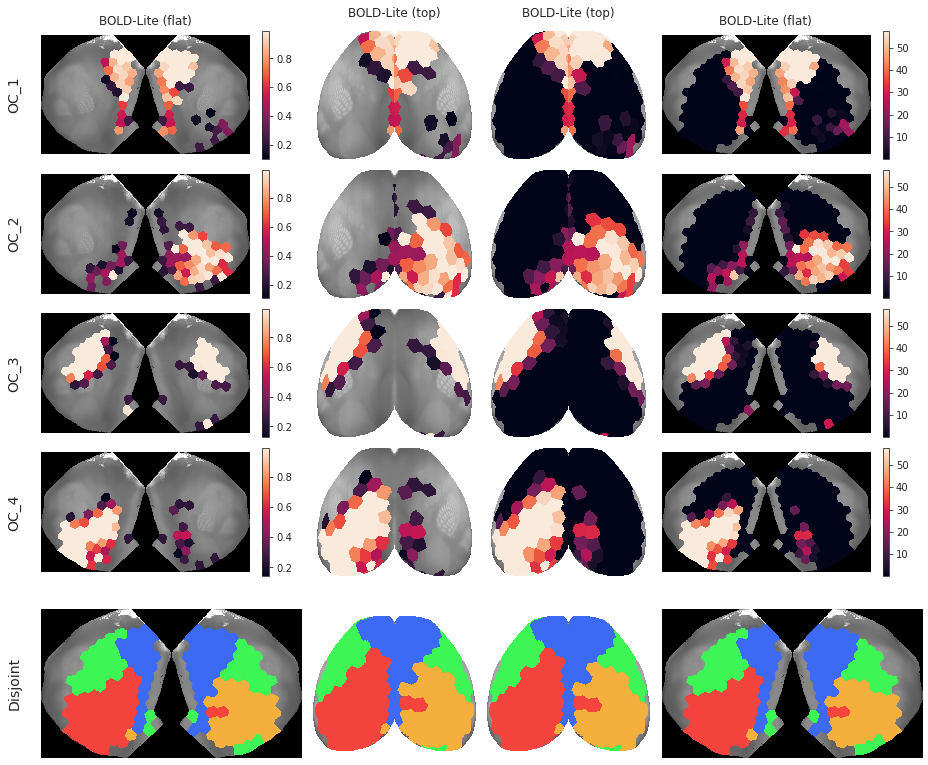

In [6]:
_ = sv.show(
    sv.project_vec(sv.pi),
    sv.project_vec(sv.gam),
    cmaps=('rocket', 'rocket'),
)

In [5]:
name = 'n168-k4-mmsb-seed15-linksampling'
run = sv._runs[sv.perc][name]
mapping = sv.perms[sv.perc][name]

In [6]:
list(run['partition_sv'].values()) == list(np.argmax(run['pi'], 0))

True

In [7]:
g1 = sv.gam_all[14]

In [8]:
g2 = run['gam'][[list(mapping.values())]]

In [9]:
c = 3
g1[:, c], g2[:, c]

(
    array([58.38109812,  0.17427196,  0.17427196,  0.17427196]),
    array([83.74999,  0.25   ,  0.25   ,  0.25   ])
)

In [10]:
0.25 / 0.17427196

1.4345394405387992

In [11]:
np.nansum(g1 * 1.4345394405387992 - g2)

-0.00036747015357707635

In [12]:
p1 = sv.pi_all[14]
p2 = run['pi'][[list(mapping.values())]]

In [13]:
c = 6
p1[:, c], p2[:, c]

(
    array([0.59522265, 0.00296201, 0.39874942, 0.00306592]),
    array([0.595, 0.003, 0.399, 0.003])
)

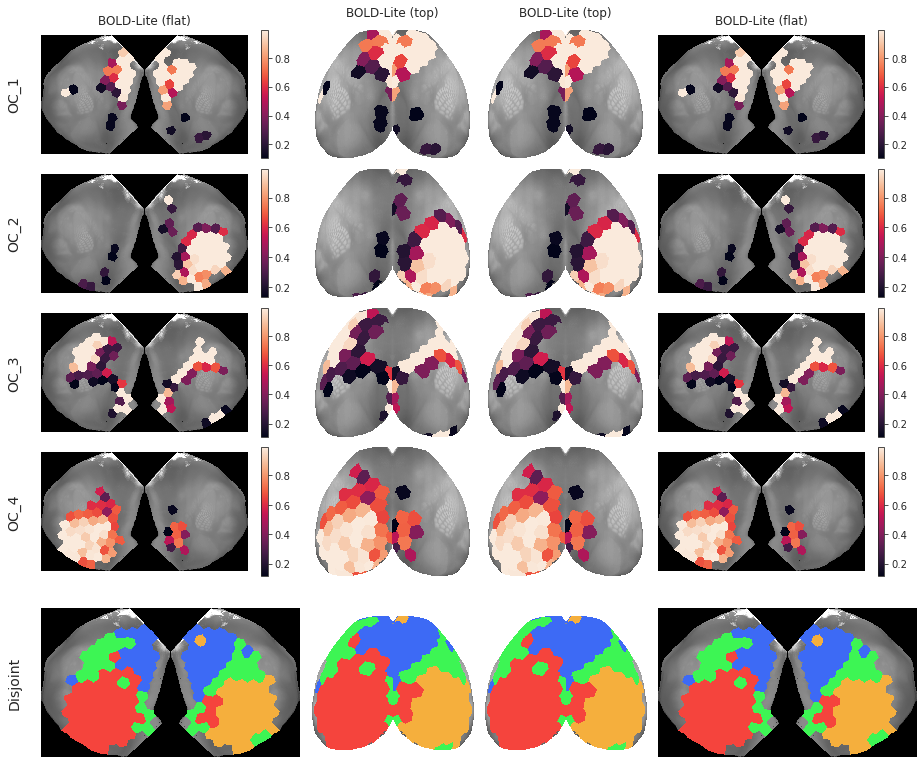

(
    <Figure size 936x792 with 28 Axes>,
    array([[<AxesSubplot:title={'center':'BOLD-Lite (flat)'}, ylabel='OC_1\n'>,
        <AxesSubplot:title={'center':'BOLD-Lite (top)'}>,
        <AxesSubplot:title={'center':'BOLD-Lite (top)'}>,
        <AxesSubplot:title={'center':'BOLD-Lite (flat)'}>],
       [<AxesSubplot:ylabel='OC_2\n'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='OC_3\n'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='OC_4\n'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Disjoint\n'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)
)

In [14]:
sv.show(
    sv.project_vec(p1),
    sv.project_vec(p2),
    cmaps=('rocket', 'rocket'),
)

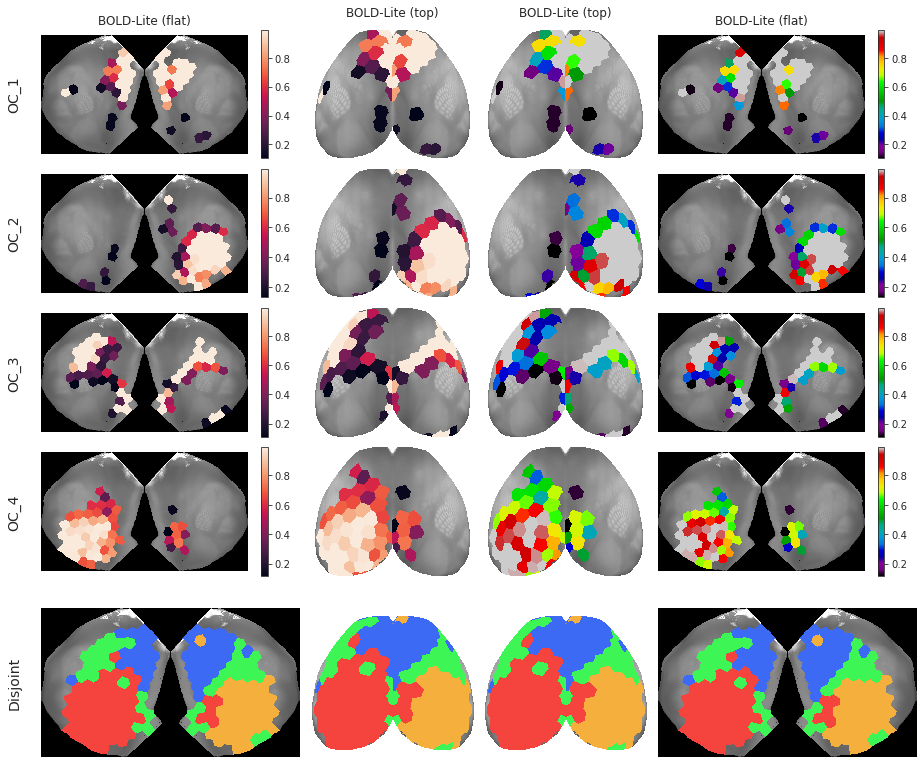

In [15]:
pi = run['pi'][list(mapping.values())]
_ = sv.show(sv.project_vec(pi))

In [47]:
mapping = sv.perms[sv.perc][name]
mapping_inv = {j: i for i, j in mapping.items()}

mapping, mapping_inv

({0: 2, 1: 0, 2: 1, 3: 3}, {2: 0, 0: 1, 1: 2, 3: 3})

In [52]:
np.argmax(run['pi'], 0)

array([2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 2, 0, 1, 2, 1, 1,
       1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 2, 3, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 2, 2, 2, 1, 3, 3, 1, 2, 1, 1, 3, 3, 3, 3, 3, 3, 2,
       0, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2,
       0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 3, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0,
       0, 2, 0, 0, 3, 1, 3, 0, 0, 0, 2, 3, 0, 3, 3, 0, 2, 0, 1, 0, 3, 3,
       0, 3, 0, 3, 2, 3, 3, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
np.argmax(pi, axis=0)

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 0, 1, 0, 1, 2, 0, 2, 2,
       2, 2, 0, 1, 0, 2, 2, 2, 2, 2, 0, 3, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 3, 2, 2, 2, 2, 0, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2,
       3, 2, 2, 2, 2, 0, 0, 0, 2, 3, 3, 2, 0, 2, 2, 3, 3, 3, 3, 3, 3, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 3, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1,
       1, 0, 1, 1, 3, 2, 3, 1, 1, 1, 0, 3, 1, 3, 3, 1, 0, 1, 2, 1, 3, 3,
       1, 3, 1, 3, 0, 3, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1])

In [16]:
pi_all = []
for name, run in sv._runs[sv.perc].items():
    mapping = sv.perms[sv.perc][name]
    pi = run['pi'][list(mapping.values())]
    pi_all.append(np.expand_dims(pi, 0))
pi_all = np.concatenate(pi_all)
pi_all.shape

(500, 4, 174)

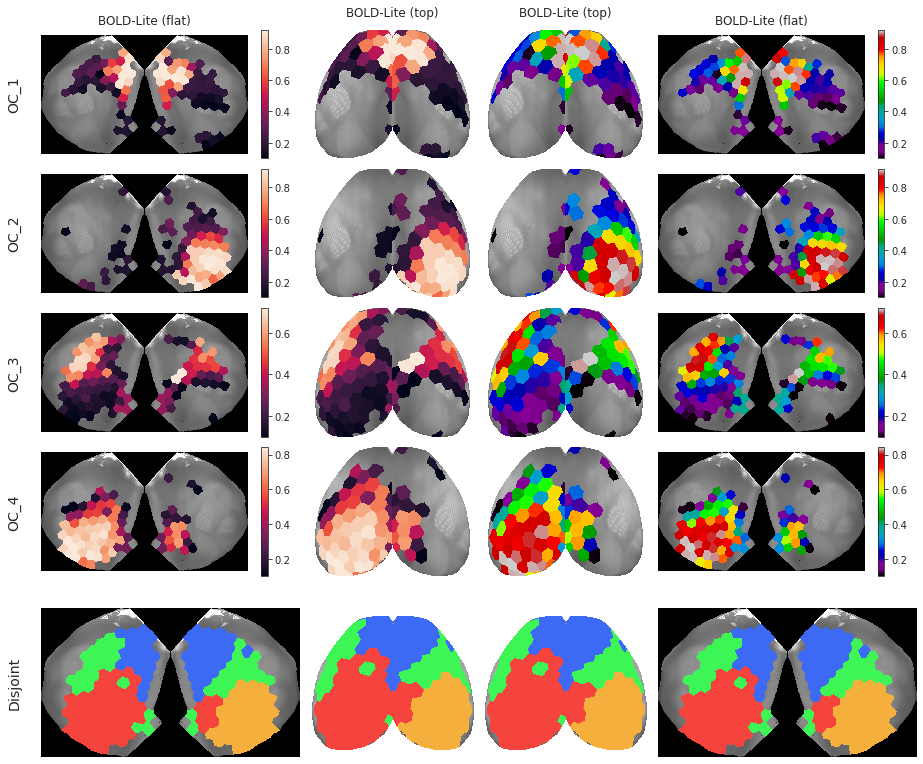

In [17]:
_ = sv.show(sv.project_vec(sv.pi))

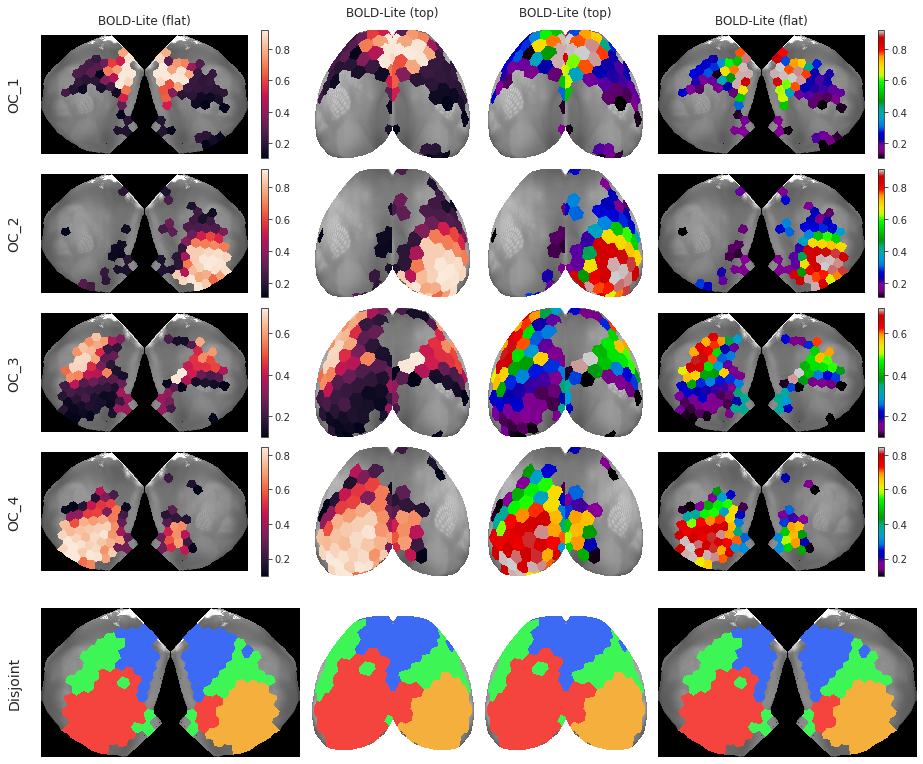

In [18]:
proj = sv.project_vec(pi_all.mean(0))
_ = sv.show(proj)

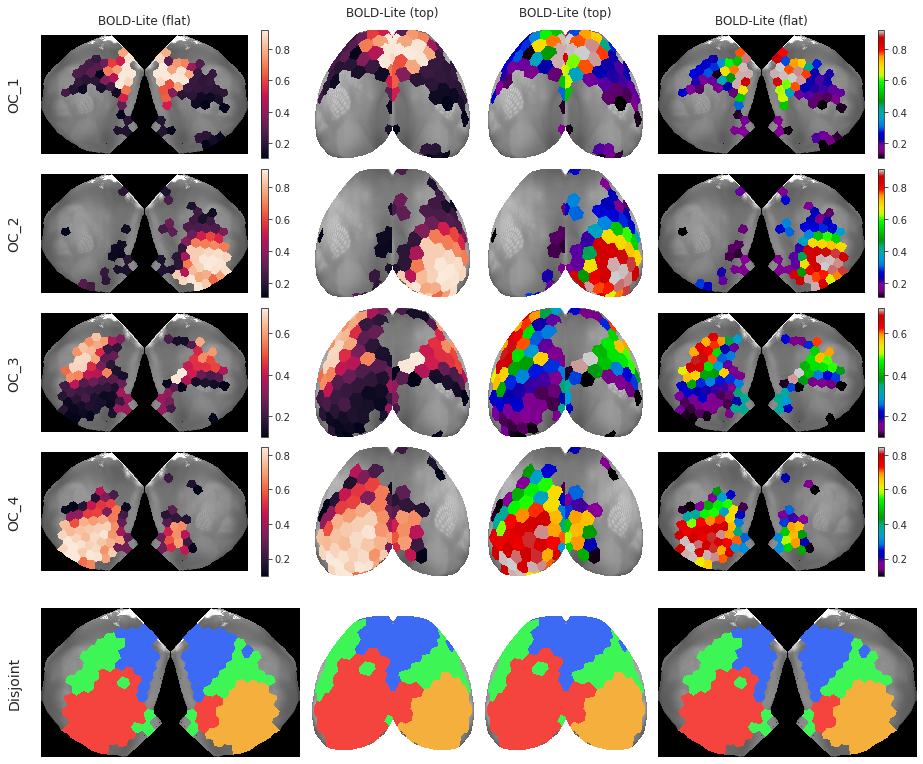

In [19]:
_ = sv.show(sv.project_vec(bn.nanmean(sv._cat_data(raw=False, which='pi'), 0)))

In [14]:
gam_all = []
for name, run in sv._runs[sv.perc].items():
    mapping = sv.perms[sv.perc][name]
    pi = run['gam'][list(mapping.values())]
    gam_all.append(np.expand_dims(pi, 0))
gam_all = np.concatenate(gam_all)
gam_all.shape

(500, 4, 174)

In [18]:
gam_all = np.where(gam_all.sum(1, keepdims=True) != 0, gam_all, np.nan)
_pi = gam_all / np.nansum(gam_all, 1, keepdims=True)

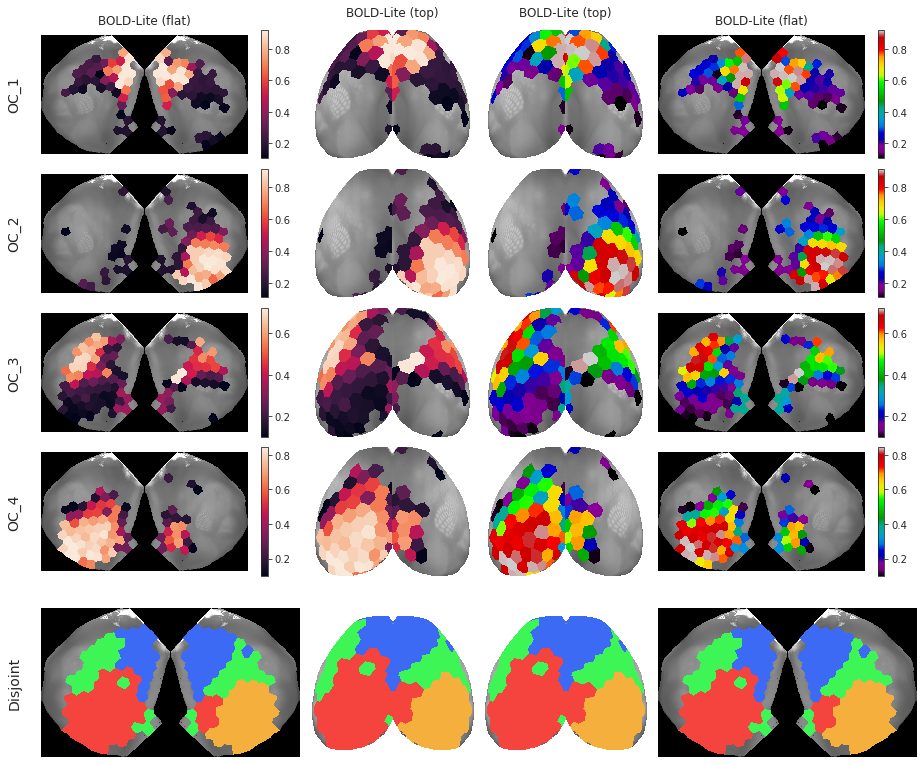

In [22]:
proj = sv.project_vec(bn.nanmean(_pi, 0))
_ = sv.show(proj)

In [14]:
for name, run in sv._runs[sv.perc].items():
    cond = list(np.argmax(run['pi'], 0)) == list(run['partition_sv'].values())
    if not cond:
        print(name)